___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-14.png" width="350px" height="180px" />


# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
#### <font color= #2E9AFE> `Martes y Viernes (Videoconferencia) de 13:00 - 15:00 hrs`</font>
- <Strong> Sara Eugenia Rodríguez </Strong>
- <Strong> Año </Strong>: 2024
- <Strong> Email: </Strong>  <font color="blue"> `cd682324@iteso.mx` </font>
___

<p style="text-align:right;"> Imagen recuperada de: https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-14.png</p>

### <font color= #2E9AFE> Tema: Series de Tiempo con Clustering</font>

#### Ejemplo: Diversificación de Portafolios

<img style="float: center; margin: 0px 0px 15px 15px;" src="https://moneymorning.com/wp-content/blogs.dir/1/files/2021/04/DIVERS1-1024x573.png" width="350px" height="180px" />

Un portafolio de inversión de activos financieros (o cartera de inversión) es la forma de agrupar diversos tipos de activos, a fin de invertir un patrimonio y alcanzar, en algún plazo definido, un objetivo de rentabilidad dada ciertas consideraciones de riesgo.

Lo que se quiere hacer es idear una estrategia en la que seleccione sólo aquellas acciones que se comporten de manera diferente. Esto ayudará a mitigar el riesgo y una forma de hacerlo es seleccionar acciones de diferentes sectores, pero una solución más basada en datos puede ser aplicar el algoritmo de agrupación K-Means en datos bursátiles para identificar diferentes grupos de acciones.

Este enfoque permite a los inversores construir portafolios diversificados basados en los grupos formados. Por ejemplo, se podrían identificar acciones con bajo riesgo y alto rendimiento en un clúster y otras con mayores fluctuaciones en otro.


**Objetivo**: aprender sobre acciones de la bolsa utilizando algoritmos de clustering para agrupar acciones que tienen un comportamiento similar. 

Vamos a enfocarnos en acciones que son parte del índice del Dow Jones. También en algunas del índice del S&P500

Tanto el Dow Jones, como el S&P 500 son índices bursátiles del mercado estadounidense.

Estos índices se calculan a partir de la cotizaciones de las empresas que se agrupan en ellos. 

**Dow Jones**

El Dow Jones aglutina las 30 mayores empresas cotizadas de Estados Unidos proveniente de los distintos sectores de la Industria excepto de transporte y energía que se miden en índices separados.

**S&P 500**

Se suelte considerar por los analistas como el indicador más próximo a la situación real en la que se encuentra el mercado.

Bajo este índice se agrupan las 500 mayores compañías estadounidenses que cotizan en bolsa, concretamente en la bolsa de Nueva York.

Estas compañías no son fijas, son seleccionadas por un comité de la firma S&P, y deben cumplir una serie de requisitos para poder ser incluidas en dicho índice, relacionados con su capitalización bursátil, liquidez, capital flotante, viabilidad financiera, antigüedad en bolsa y su negociación en la bolsa de valores.

### Datos

Vamos a utilizar varias fuentes de datos:
- Lista de compañías que son parte del índice del Dow Jones: https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
- Datos de los últimos 5 años del índice del S&P500
- Alguna información sobre los componentes de las acciones del S&P500, principalmente el símbolo de cada compañía

#### S&P500

Se tienen datos de acciones de cada compañía que es parte del índice, etiquetadas por su nombre de cotización en la bolsa. 

- Date: en formato yy-mm-dd
- Open: precio de la acción cuando el mercado abre (USD)
- Low: precio más bajo alcanzado durante el día
- Close: precio al que se cierra en el día
- High: precio más alto alcanzado durante el día
- Volume: número de acciones negociadas
- Name: nombre de la acción en la bolsa


In [ ]:
pip install yfinance

In [2]:
#librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import yfinance as yf
from datetime import datetime, timedelta

random.seed(42)
plt.rcParams['figure.figsize'] = (7,4.5) 

In [3]:
# Obtener la lista de empresas del S&P 500, (se puede descargar de wikipedia)
def get_sp500_tickers():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    table = pd.read_html(url)
    sp500_table = table[0]
    tickers = sp500_table['Symbol'].tolist()
    return tickers

start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

def download_prices(tickers, start_date, end_date):
    print("Descargando datos de cierre ajustado para el S&P 500...")
    data = yf.download(tickers, start=start_date, end=end_date, group_by="ticker", progress=True)
    return data

tickers = get_sp500_tickers()

data = download_prices(tickers, start_date, end_date)

data_close = data.loc[:, (slice(None), 'Adj Close')]  # Seleccionar solo los precios de cierre ajustados
data_close.columns = [col[0] for col in data_close.columns] 
data_close.reset_index(inplace=True)

data_close.to_excel("sp500_prices.xlsx", index=False)


Descargando datos de cierre ajustado para el S&P 500...


[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-11-28 -> 2024-11-26)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


In [4]:
#Cargar precios de las acciones del S&P500
data = pd.read_excel('sp500_prices.xlsx')
data = data.rename(columns={'Name':'symbol'})
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,DGX,AVB,IR,GPN,ACN,IT,XOM,AZO,AIZ,...,JKHY,FFIV,SO,YUM,DXCM,HOLX,CDNS,BEN,OKE,DVN
0,2019-11-29,96.240959,180.234039,33.731400,174.880112,186.910400,160.460007,53.457714,1177.920044,121.613556,...,143.690125,145.710007,50.815769,92.168083,56.827499,51.320000,70.250000,21.810499,50.120216,16.390028
1,2019-12-02,96.195808,177.535706,33.402752,171.954193,185.451599,157.619995,53.685257,1177.650024,120.551819,...,142.271576,144.490005,50.496071,92.067375,55.980000,51.540001,67.480003,21.405863,49.957977,16.345102
2,2019-12-03,95.391899,179.469070,33.133858,171.326477,184.671158,157.649994,53.261551,1152.300049,117.613754,...,141.997330,144.419998,51.127274,91.051117,57.165001,51.689999,65.220001,20.929829,49.513565,16.030634
3,2019-12-04,96.015167,180.999008,33.243401,169.926331,185.442337,157.729996,53.865730,1163.089966,118.162926,...,142.895737,143.580002,51.389584,90.822227,57.294998,52.139999,65.930000,21.001230,49.965027,16.764400
4,2019-12-05,95.879684,181.494995,33.382835,170.843689,185.693222,158.470001,53.677406,1162.660034,119.361946,...,142.536331,137.960007,51.446968,90.199661,56.700001,52.279999,65.809998,20.993298,50.070847,16.524803


In [6]:
data.isna().sum()>0

Date    False
DGX     False
AVB     False
IR      False
GPN     False
        ...  
HOLX    False
CDNS    False
BEN     False
OKE     False
DVN     False
Length: 504, dtype: bool

In [7]:
#Quitar esas columnas que tienen todas las filas con datos nulos
data = data.dropna(axis=1, how='all')

In [8]:
#Observamos el porcentaje de nulos que tienen las acciones
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

CARR     5.971338
AMTM    96.417197
OTIS     5.971338
PLTR    16.719745
KVUE    68.630573
SW      92.038217
ABNB    20.700637
SOLV    86.703822
CEG     42.834395
VLTO    76.990446
GEHC    61.066879
GEV     86.703822
dtype: float64

In [9]:
#Vamos a quitar esas acciones que tienen gran porcentaje de datos nulos
dropping = data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]
dropping[dropping>1].index
data = data.drop(columns=['SW', 'AMTM', 'VLTO', 'CARR', 'PLTR', 'SOLV', 'KVUE', 'CEG', 'OTIS', 'ABNB', 'GEHC', 'GEV'], axis=1)

In [10]:
#Quitamos los valores nulos
data = data.dropna()
data[data.columns[data.isnull().any()]].isnull().sum() * 100 / data.shape[0]

Series([], dtype: float64)

#### Lista de las industrias a las que pertenecen las compañías del S&P500 

Las descargamos de aquí:
https://en.wikipedia.org/wiki/List_of_S%26P_500_companies

In [11]:
def get_sp500_companies():
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    tables = pd.read_html(url)
    
    sp500_table = tables[0]
    
    sp500_companies = sp500_table[["Symbol", "Security", "GICS Sector", "GICS Sub-Industry"]]
    
    sp500_companies.columns = ["Symbol", "Security", "Sector", "Sub-Industry"]
    
    return sp500_companies

companies = get_sp500_companies()

companies.to_csv("sp500_companies.csv", index=False)


In [12]:
companies = companies.set_index(['Symbol'])
companies.head()

,Security,Sector,Sub-Industry
Symbol,,,
MMM,3M,Industrials,Industrial Conglomerates
AOS,A. O. Smith,Industrials,Building Products
ABT,Abbott Laboratories,Health Care,Health Care Equipment
ABBV,AbbVie,Health Care,Biotechnology
ACN,Accenture,Information Technology,IT Consulting & Other Services


#### Lista de las compañías del Dow Jones

Las podemos descargar de aquí:
https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

In [13]:
import pandas as pd

def get_dow_jones_companies():
    url = "https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average"
    
    tables = pd.read_html(url)
    
    dow_table = tables[2]
    
    dow_companies = dow_table[["Symbol", "Company"]]
    
    dow_companies.columns = ["Symbol", "Company"]
    
    return dow_companies

dow_data = get_dow_jones_companies()

dow_data.to_csv("dow_jones_companies.csv", index=False)


In [14]:
dow_data.set_index("Symbol", inplace=True)
dow_data.head()

,Company
Symbol,
MMM,3M
AXP,American Express
AMGN,Amgen
AMZN,Amazon
AAPL,Apple


#### Preparar datos del S&P

In [15]:
data

,Date,DGX,AVB,IR,GPN,ACN,IT,XOM,AZO,AIZ,...,JKHY,FFIV,SO,YUM,DXCM,HOLX,CDNS,BEN,OKE,DVN
0,2019-11-29,96.240959,180.234039,33.731400,174.880112,186.910400,160.460007,53.457714,1177.920044,121.613556,...,143.690125,145.710007,50.815769,92.168083,56.827499,51.320000,70.250000,21.810499,50.120216,16.390028
1,2019-12-02,96.195808,177.535706,33.402752,171.954193,185.451599,157.619995,53.685257,1177.650024,120.551819,...,142.271576,144.490005,50.496071,92.067375,55.980000,51.540001,67.480003,21.405863,49.957977,16.345102
2,2019-12-03,95.391899,179.469070,33.133858,171.326477,184.671158,157.649994,53.261551,1152.300049,117.613754,...,141.997330,144.419998,51.127274,91.051117,57.165001,51.689999,65.220001,20.929829,49.513565,16.030634
3,2019-12-04,96.015167,180.999008,33.243401,169.926331,185.442337,157.729996,53.865730,1163.089966,118.162926,...,142.895737,143.580002,51.389584,90.822227,57.294998,52.139999,65.930000,21.001230,49.965027,16.764400
4,2019-12-05,95.879684,181.494995,33.382835,170.843689,185.693222,158.470001,53.677406,1162.660034,119.361946,...,142.536331,137.960007,51.446968,90.199661,56.700001,52.279999,65.809998,20.993298,50.070847,16.524803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2024-11-19,161.160004,229.380005,102.379997,114.720001,353.950012,517.729980,118.629997,3106.909912,219.169998,...,171.630005,239.669998,88.290001,132.139999,74.879997,78.570000,299.630005,21.480000,113.110001,37.910000
1252,2024-11-20,161.320007,228.139999,103.110001,114.830002,357.070007,518.000000,120.320000,3049.580078,220.850006,...,171.119995,242.020004,87.970001,132.880005,75.239998,78.040001,304.010010,21.639999,113.160004,38.299999
1253,2024-11-21,163.889999,230.630005,103.040001,116.330002,361.049988,519.239990,121.930000,3068.689941,225.220001,...,172.500000,244.289993,88.139999,134.220001,74.459999,78.720001,306.510010,21.719999,116.750000,38.700001
1254,2024-11-22,163.589996,231.940002,104.000000,117.080002,358.660004,519.780029,121.790001,3099.379883,226.149994,...,172.500000,246.979996,87.599998,135.270004,72.830002,78.970001,311.869995,21.959999,117.050003,39.450001


In [16]:
#Transformando los datos del S&P500 a serie de tiempo
acciones = data.set_index("Date")
acciones

,DGX,AVB,IR,GPN,ACN,IT,XOM,AZO,AIZ,RMD,...,JKHY,FFIV,SO,YUM,DXCM,HOLX,CDNS,BEN,OKE,DVN
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-29,96.240959,180.234039,33.731400,174.880112,186.910400,160.460007,53.457714,1177.920044,121.613556,143.399063,...,143.690125,145.710007,50.815769,92.168083,56.827499,51.320000,70.250000,21.810499,50.120216,16.390028
2019-12-02,96.195808,177.535706,33.402752,171.954193,185.451599,157.619995,53.685257,1177.650024,120.551819,142.833496,...,142.271576,144.490005,50.496071,92.067375,55.980000,51.540001,67.480003,21.405863,49.957977,16.345102
2019-12-03,95.391899,179.469070,33.133858,171.326477,184.671158,157.649994,53.261551,1152.300049,117.613754,143.274460,...,141.997330,144.419998,51.127274,91.051117,57.165001,51.689999,65.220001,20.929829,49.513565,16.030634
2019-12-04,96.015167,180.999008,33.243401,169.926331,185.442337,157.729996,53.865730,1163.089966,118.162926,143.926239,...,142.895737,143.580002,51.389584,90.822227,57.294998,52.139999,65.930000,21.001230,49.965027,16.764400
2019-12-05,95.879684,181.494995,33.382835,170.843689,185.693222,158.470001,53.677406,1162.660034,119.361946,143.954987,...,142.536331,137.960007,51.446968,90.199661,56.700001,52.279999,65.809998,20.993298,50.070847,16.524803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,161.160004,229.380005,102.379997,114.720001,353.950012,517.729980,118.629997,3106.909912,219.169998,238.119995,...,171.630005,239.669998,88.290001,132.139999,74.879997,78.570000,299.630005,21.480000,113.110001,37.910000
2024-11-20,161.320007,228.139999,103.110001,114.830002,357.070007,518.000000,120.320000,3049.580078,220.850006,241.550003,...,171.119995,242.020004,87.970001,132.880005,75.239998,78.040001,304.010010,21.639999,113.160004,38.299999
2024-11-21,163.889999,230.630005,103.040001,116.330002,361.049988,519.239990,121.930000,3068.689941,225.220001,243.600006,...,172.500000,244.289993,88.139999,134.220001,74.459999,78.720001,306.510010,21.719999,116.750000,38.700001


In [17]:
#Hacer que los datos sean semanales en lugar de diarios
acciones = acciones.resample('W').last() #se queda con el últimpo precio de cada semana
acciones.head()

,DGX,AVB,IR,GPN,ACN,IT,XOM,AZO,AIZ,RMD,...,JKHY,FFIV,SO,YUM,DXCM,HOLX,CDNS,BEN,OKE,DVN
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-01,96.240959,180.234039,33.731400,174.880112,186.910400,160.460007,53.457714,1177.920044,121.613556,143.399063,...,143.690125,145.710007,50.815769,92.168083,56.827499,51.320000,70.250000,21.810499,50.120216,16.390028
2019-12-08,96.575180,181.520172,33.950493,170.592621,188.201950,159.679993,54.540524,1172.660034,120.432823,144.348007,...,142.470169,138.000000,50.938732,90.428551,56.189999,52.740002,67.180000,21.421732,50.501141,17.325954
2019-12-15,95.021606,175.383774,35.394569,172.977432,192.020782,157.669998,54.320831,1235.319946,119.123978,147.261993,...,137.940247,139.250000,49.807480,91.655365,50.957500,53.150002,67.919998,20.620398,51.615715,17.648357
2019-12-22,96.755852,174.854156,36.490059,177.347015,196.146286,153.050003,54.877911,1226.739990,120.139908,149.466675,...,138.848114,138.320007,52.348694,92.094826,53.355000,52.020000,70.089996,20.469652,53.040665,19.144098
2019-12-29,96.511948,175.551865,36.798798,176.805649,197.186981,153.820007,54.838703,1202.589966,118.675491,149.725449,...,138.649536,139.169998,52.020786,93.294205,54.527500,52.360001,70.290001,20.826683,53.407486,19.339533


#### Análisis Exploratorio

In [18]:
#Función para extraer el símbolo de la acción
def get_name(symbol):
    name = symbol
    try:
        name = companies.loc[symbol]['security']
    except KeyError:
        pass
    return name

#Función para graficar la acción
def plot_stock(symbol, stocks=acciones):
    name = get_name(symbol)
    stocks[symbol].plot(title=name, label=name, alpha=0.9);

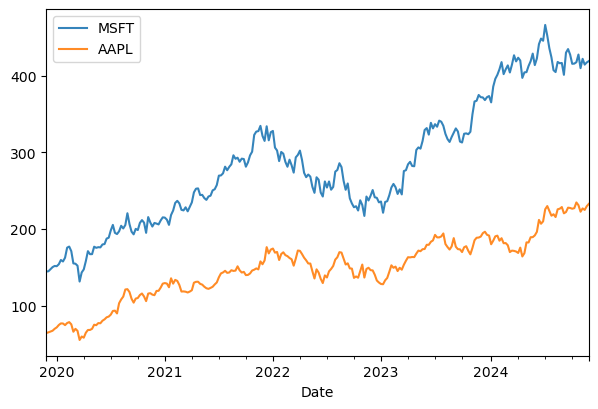

In [19]:
plot_stock('MSFT')
plot_stock('AAPL')
plt.title('')
plt.legend()

#### Calcular los rendimientos para poder comparar las acciones

**Qué es un rendimiento?**

El rendimiento es uno de los principales indicadores de las inversiones en acciones, mediante el cual se puede evaluar su rentabilidad, viabilidad y compararlas entre sí. 

El rendimiento se calcula mediante la fórmula:

$$\frac{(\text{precio de venta - precio de compra}) }{ \text{precio de compra}} * 100\%$$

In [20]:
#Rendimientos
start = acciones.iloc[0]
rendimientos = (acciones - start) / start

In [21]:
rendimientos

,DGX,AVB,IR,GPN,ACN,IT,XOM,AZO,AIZ,RMD,...,JKHY,FFIV,SO,YUM,DXCM,HOLX,CDNS,BEN,OKE,DVN
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-08,0.003473,0.007136,0.006495,-0.024517,0.006910,-0.004861,0.020255,-0.004466,-0.009709,0.006618,...,-0.008490,-0.052913,0.002420,-0.018873,-0.011218,0.027670,-0.043701,-0.017825,0.007600,0.057103
2019-12-15,-0.012670,-0.026911,0.049306,-0.010880,0.027341,-0.017388,0.016146,0.048730,-0.020471,0.026938,...,-0.040016,-0.044335,-0.019842,-0.005563,-0.103295,0.035659,-0.033167,-0.054566,0.029838,0.076774
2019-12-22,0.005350,-0.029849,0.081783,0.014106,0.049413,-0.046180,0.026567,0.041446,-0.012117,0.042313,...,-0.033698,-0.050717,0.030166,-0.000795,-0.061106,0.013640,-0.002278,-0.061477,0.058269,0.168033
2019-12-29,0.002816,-0.025978,0.090936,0.011011,0.054981,-0.041381,0.025833,0.020944,-0.024159,0.044117,...,-0.035080,-0.044884,0.023713,0.012218,-0.040473,0.020265,0.000569,-0.045107,0.065588,0.179957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-03,0.613554,0.199995,1.785298,-0.402791,0.849389,2.139038,1.132772,1.530893,0.576798,0.699822,...,0.273992,0.593576,0.728105,0.435855,0.237957,0.604248,3.015516,-0.044497,0.862721,1.338007
2024-11-10,0.655948,0.296925,2.041390,-0.365966,0.902141,2.411442,1.247065,1.640349,0.721765,0.759984,...,0.251095,0.656098,0.730057,0.488693,0.231094,0.534684,3.288256,-0.035327,1.138059,1.371564
2024-11-17,0.667066,0.272845,2.036637,-0.336688,0.891655,2.258507,1.231857,1.638150,0.799306,0.636970,...,0.205441,0.635852,0.716200,0.449417,0.335269,0.531567,3.123986,-0.006442,1.190932,1.347159


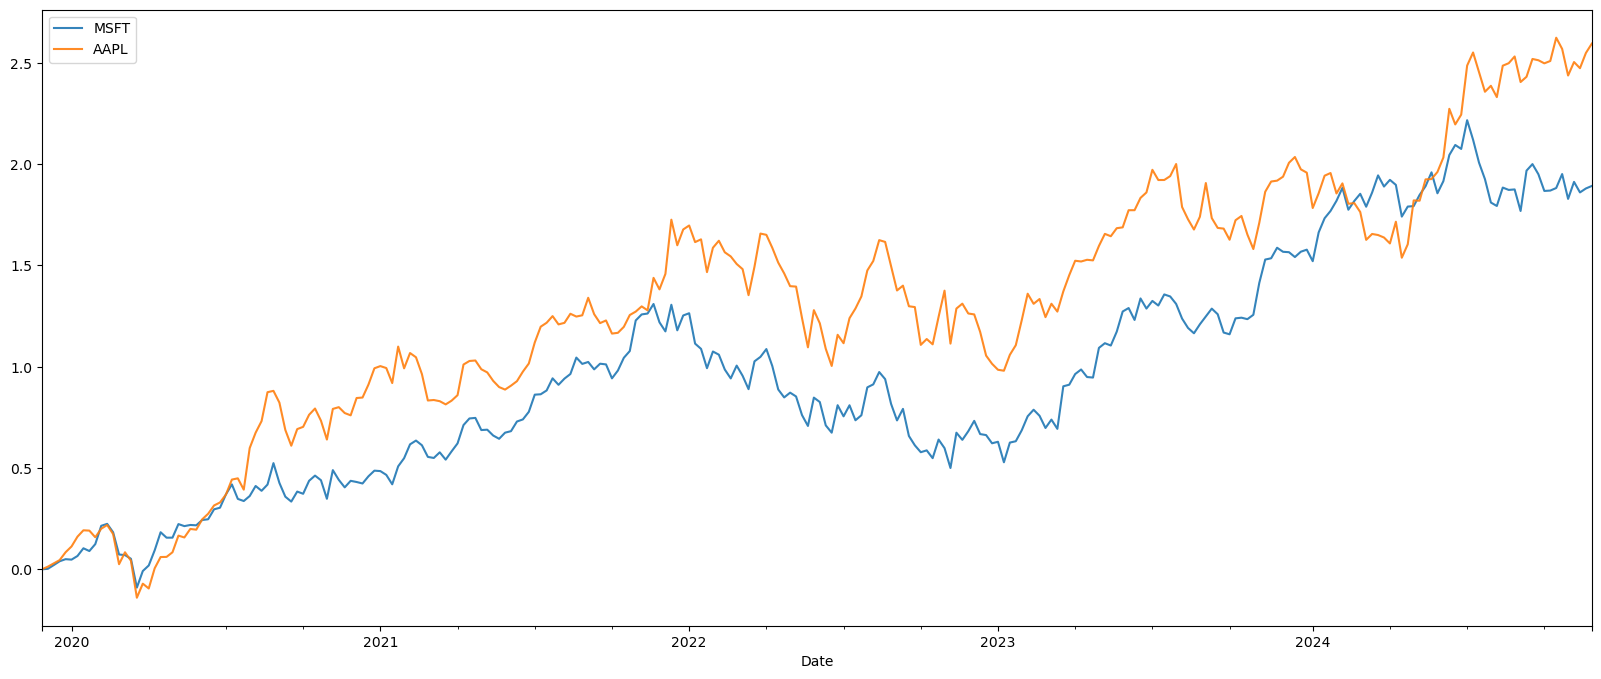

In [22]:
#Graficar rendimientos
plt.figure(figsize = (20,8))
plot_stock('MSFT', stocks=rendimientos)
plot_stock('AAPL', stocks=rendimientos)
plt.title('')
plt.legend();

#### ¿Cuáles son las mejores y peores acciones de los últimos 5 años?

In [23]:
mejores = rendimientos.iloc[-1].sort_values(ascending=False).head()
peores = rendimientos.iloc[-1].sort_values().head()

In [24]:
print('Mejores acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in mejores.index.tolist()]}, index = mejores.index)
mejores = pd.concat((mejores, names), axis=1)
mejores

Mejores acciones


,2024-12-01 00:00:00,name
NVDA,24.206393,NVDA
SMCI,17.032863,SMCI
TSLA,14.393253,TSLA
AXON,7.387534,AXON
PWR,7.346051,PWR


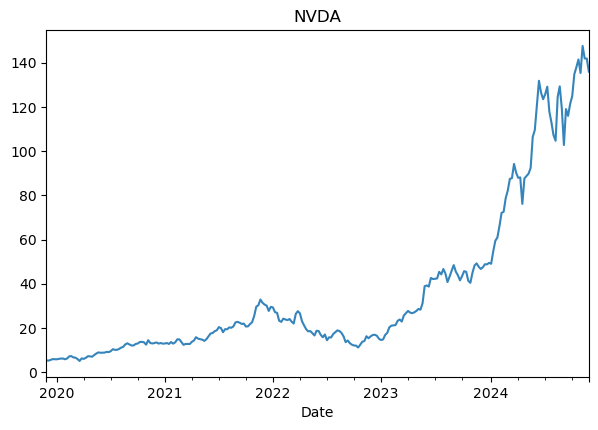

In [25]:
plot_stock('NVDA')

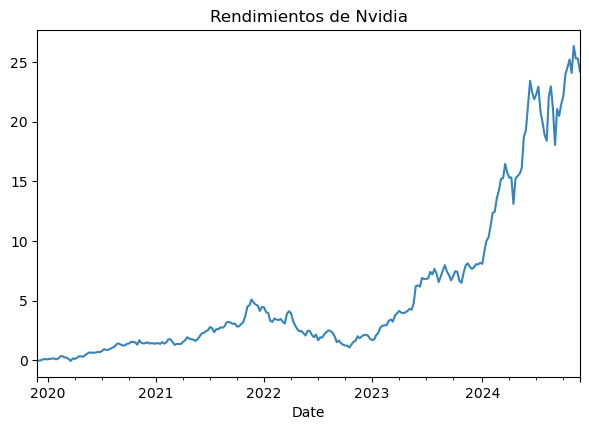

In [26]:
plot_stock('NVDA', stocks=rendimientos)
plt.title('Rendimientos de Nvidia');

In [27]:
print('Peores acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in peores.index.tolist()]}, index = peores.index)
peores = pd.concat((peores, names), axis=1)
peores

Peores acciones


,2024-12-01 00:00:00,name
WBA,-0.800066,WBA
WBD,-0.684274,WBD
PARA,-0.683776,PARA
EL,-0.605017,EL
BA,-0.579412,BA


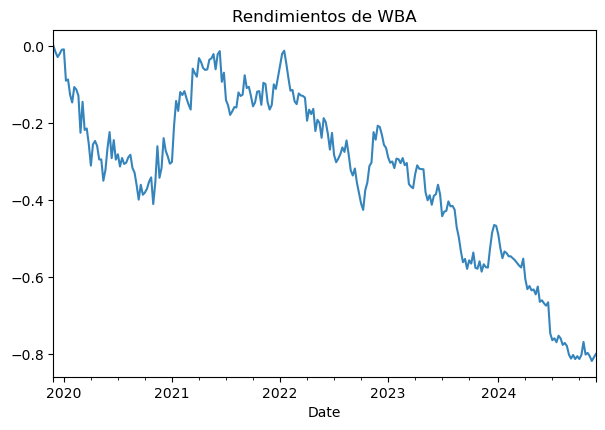

In [28]:
plot_stock('WBA', stocks=rendimientos)
plt.title('Rendimientos de WBA');

#### Enfocándonos en las acciones del Dow Jones

In [29]:
dow_acciones = [s for s in dow_data.index if s in acciones.columns]
dow_rendimientos = rendimientos[dow_acciones]

In [30]:
print(dow_acciones)

['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'NVDA', 'PG', 'CRM', 'SHW', 'TRV', 'UNH', 'VZ', 'V', 'WMT']


In [31]:
mejores_dow = dow_rendimientos.iloc[-1].sort_values(ascending=False).head()
peores_dow = dow_rendimientos.iloc[-1].sort_values().head()
print('Mejores acciones del Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in mejores_dow.index.tolist()]}, index = mejores_dow.index)
mejores_dow = pd.concat((mejores_dow, names), axis=1)
mejores_dow

Mejores acciones del Dow Jones


,2024-12-01 00:00:00,name
NVDA,24.206393,NVDA
AAPL,2.595140,AAPL
CAT,2.127978,CAT
GS,2.063812,GS
MSFT,1.892341,MSFT


In [32]:
print('Peores acciones del Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in peores_dow.index.tolist()]}, index = peores_dow.index)
peores_dow = pd.concat((peores_dow, names), axis=1)
peores_dow

Peores acciones del Dow Jones


,2024-12-01 00:00:00,name
BA,-0.579412,BA
DIS,-0.224070,DIS
NKE,-0.106579,NKE
VZ,-0.038043,VZ
MMM,0.123713,MMM


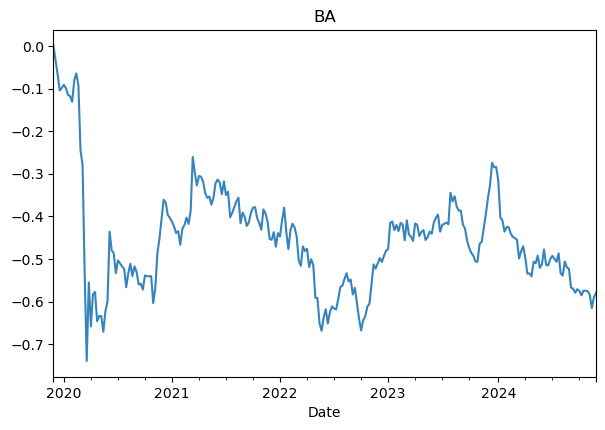

In [33]:
plot_stock('BA', stocks=rendimientos);

#### Clustering

In [34]:
dow_rendimientos.head()

,MMM,AXP,AMGN,AMZN,AAPL,BA,CAT,CVX,CSCO,KO,...,NKE,NVDA,PG,CRM,SHW,TRV,UNH,VZ,V,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-08,0.010013,0.004079,-0.004047,-0.027321,0.012947,-0.033017,-0.013888,0.007513,-0.032443,0.019101,...,0.037544,-0.021085,0.017450,-0.029959,-0.007871,-0.007314,0.004992,0.015770,-0.012682,0.010305
2019-12-15,-0.005773,0.038295,0.008606,-0.022135,0.029560,-0.066934,0.005528,0.007086,-0.000221,0.019101,...,0.045780,0.033450,0.027937,-0.010805,-0.018692,-0.001722,0.023967,0.009462,0.003415,0.014607
2019-12-22,0.032986,0.047036,0.035532,-0.007941,0.045613,-0.104266,0.019623,0.021771,0.047230,0.029401,...,0.069205,0.104411,0.027036,0.010191,-0.003687,0.003944,0.049469,0.030378,0.018915,0.014607
2019-12-29,0.044118,0.042208,0.029013,0.038316,0.084378,-0.098421,0.024529,0.027064,0.054292,0.036517,...,0.086426,0.092877,0.033017,0.012831,-0.002469,0.006667,0.061592,0.021414,0.026448,0.008703


In [35]:
dow_rendimientos.shape

(262, 30)

C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the envir

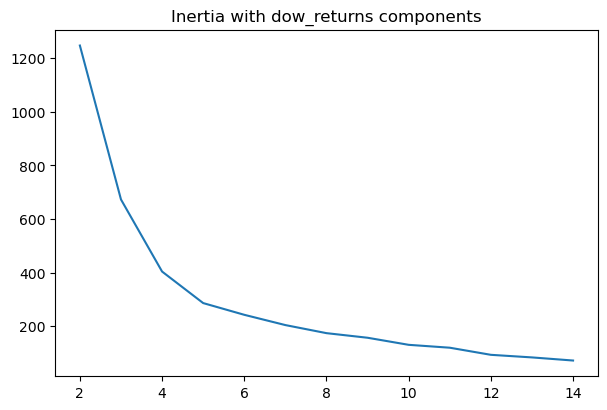

In [36]:
#gráfica de codo para encontrar el k optimo
inertias = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dow_rendimientos.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,15), inertias)
plt.title('Inertia with dow_returns components');

In [ ]:
#pip install kneed

In [37]:
from kneed import KneeLocator
kl = KneeLocator(
     range(2, 15), inertias, curve="convex", direction="decreasing")

kl.elbow

5

In [38]:
#Aplicar el kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(dow_rendimientos.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

#Asignar cada dato a un cluster
for i,l in enumerate(kmeans.predict(dow_rendimientos.T)):
    clusters[l].append(dow_rendimientos.columns[i])

    #Que imprima los clusters    
for c in sorted(clusters):
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Saruki\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 0: AXP (AXP) ### AMZN (AMZN) ### CAT (CAT) ### GS (GS) ### HD (HD) ### UNH (UNH) ### 

Cluster 1: NVDA (NVDA) ### 

Cluster 2: AMGN (AMGN) ### CVX (CVX) ### CSCO (CSCO) ### KO (KO) ### HON (HON) ### IBM (IBM) ### JNJ (JNJ) ### JPM (JPM) ### MCD (MCD) ### MRK (MRK) ### NKE (NKE) ### PG (PG) ### CRM (CRM) ### SHW (SHW) ### TRV (TRV) ### V (V) ### WMT (WMT) ### 

Cluster 3: MMM (MMM) ### BA (BA) ### DIS (DIS) ### VZ (VZ) ### 

Cluster 4: AAPL (AAPL) ### MSFT (MSFT) ### 



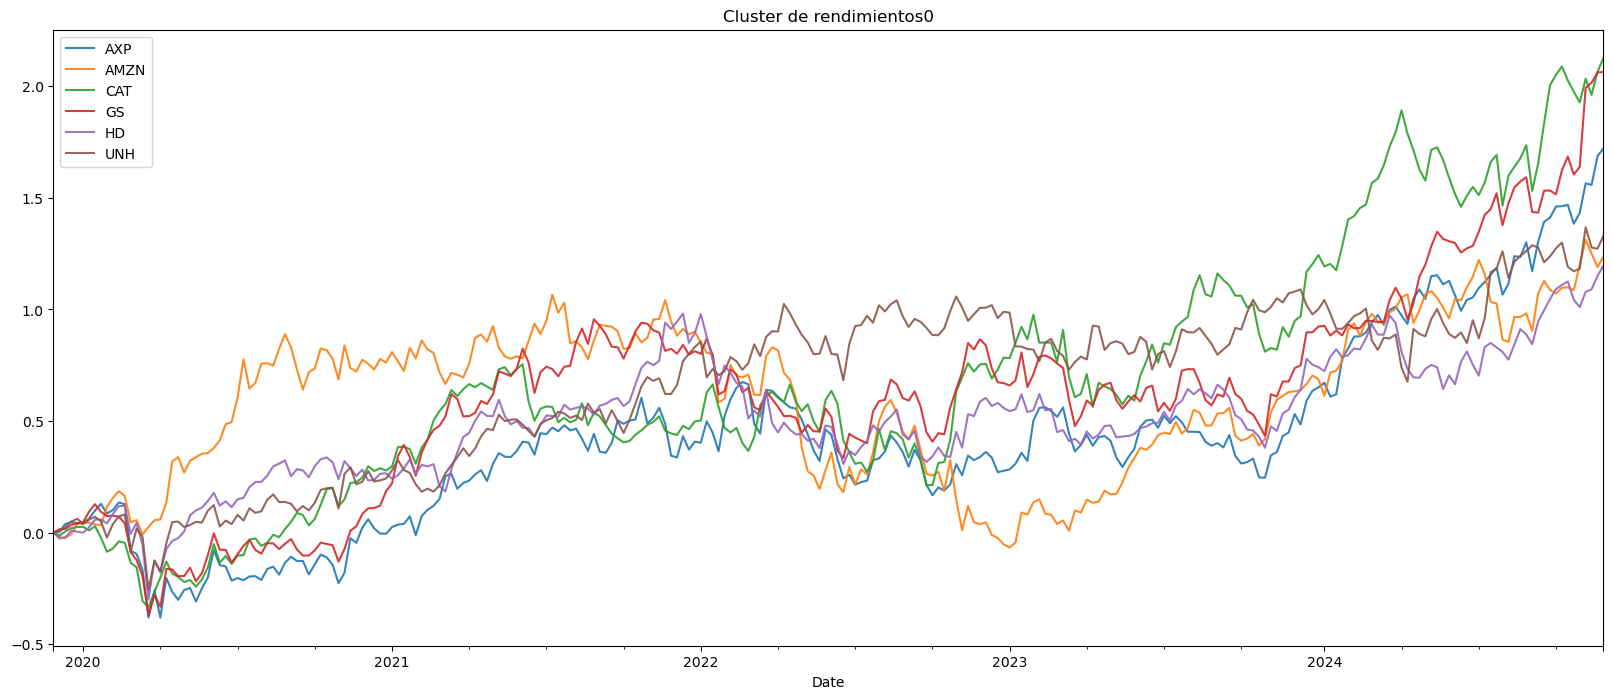

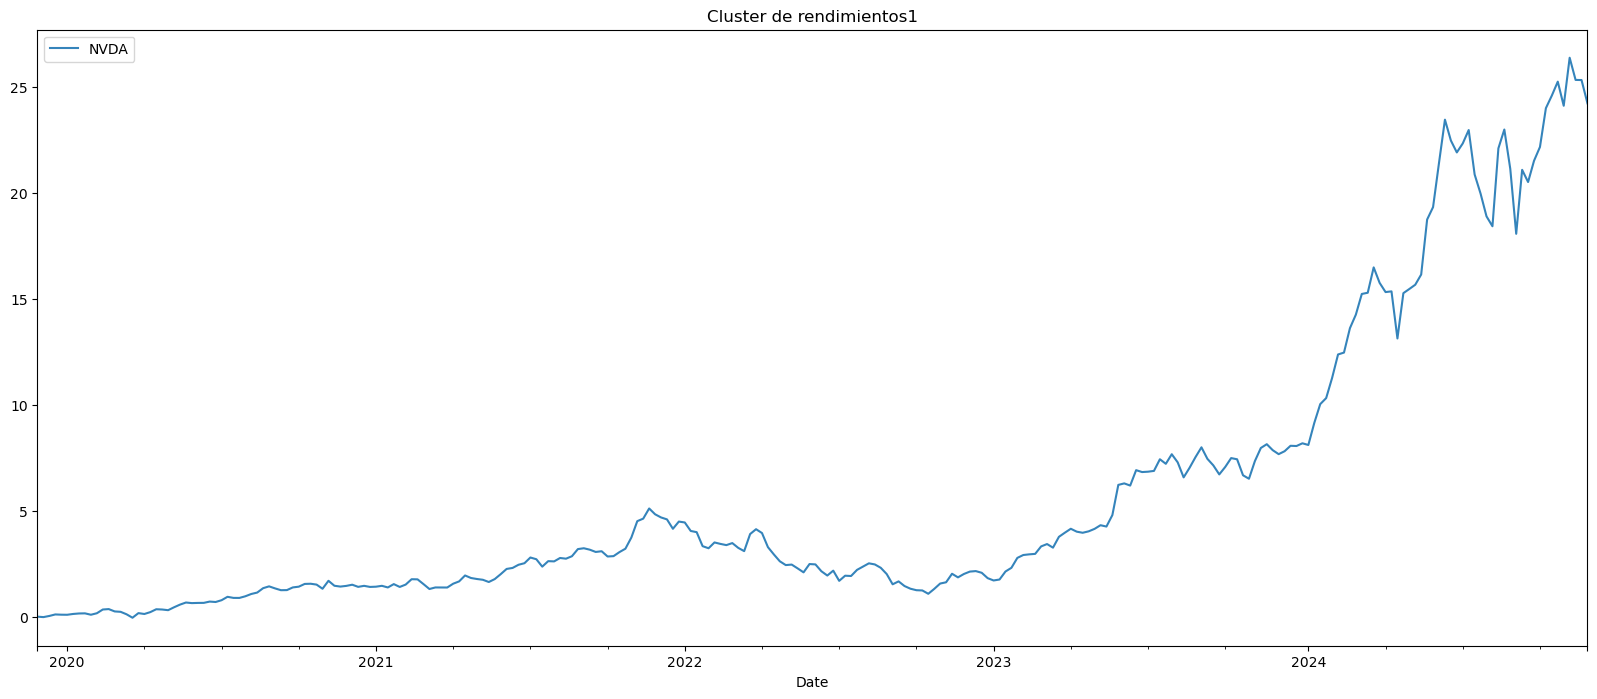

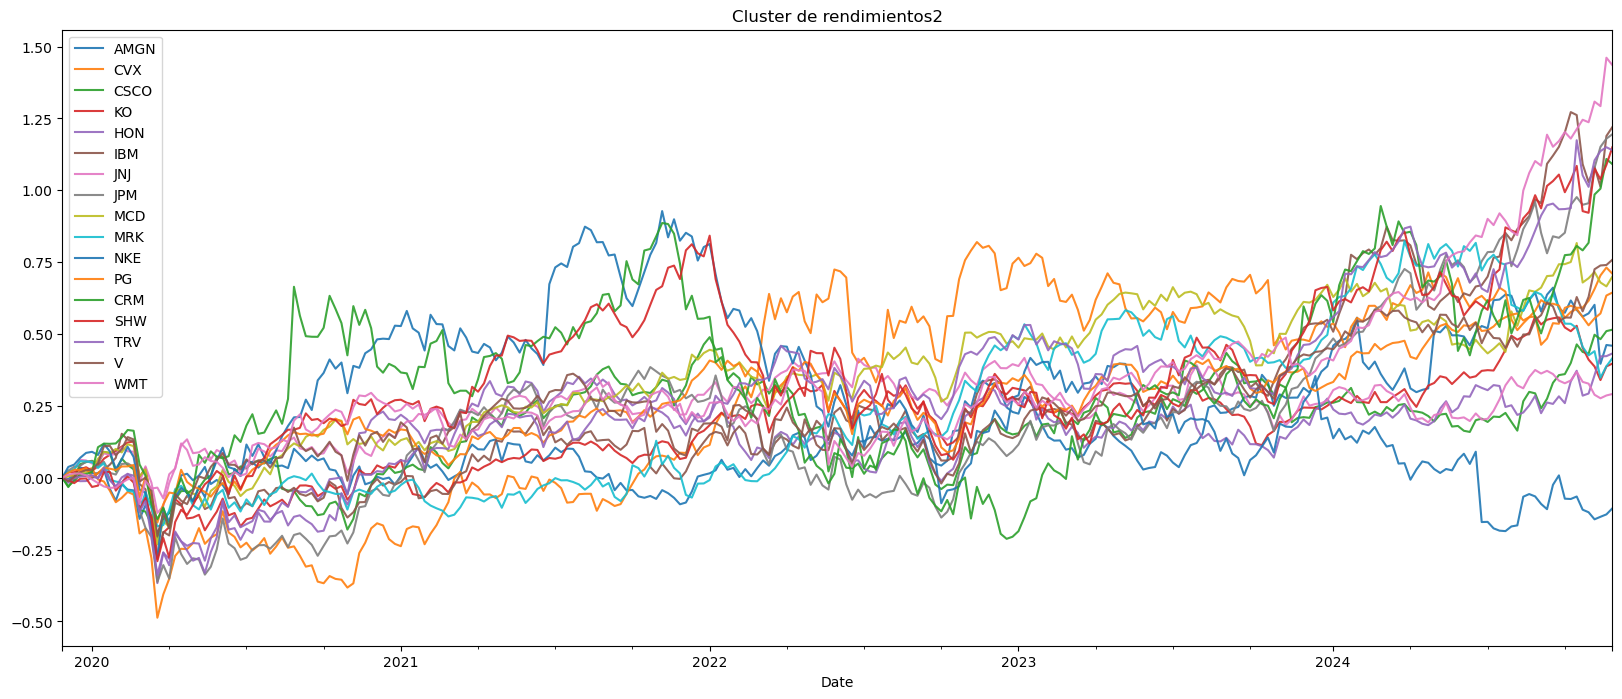

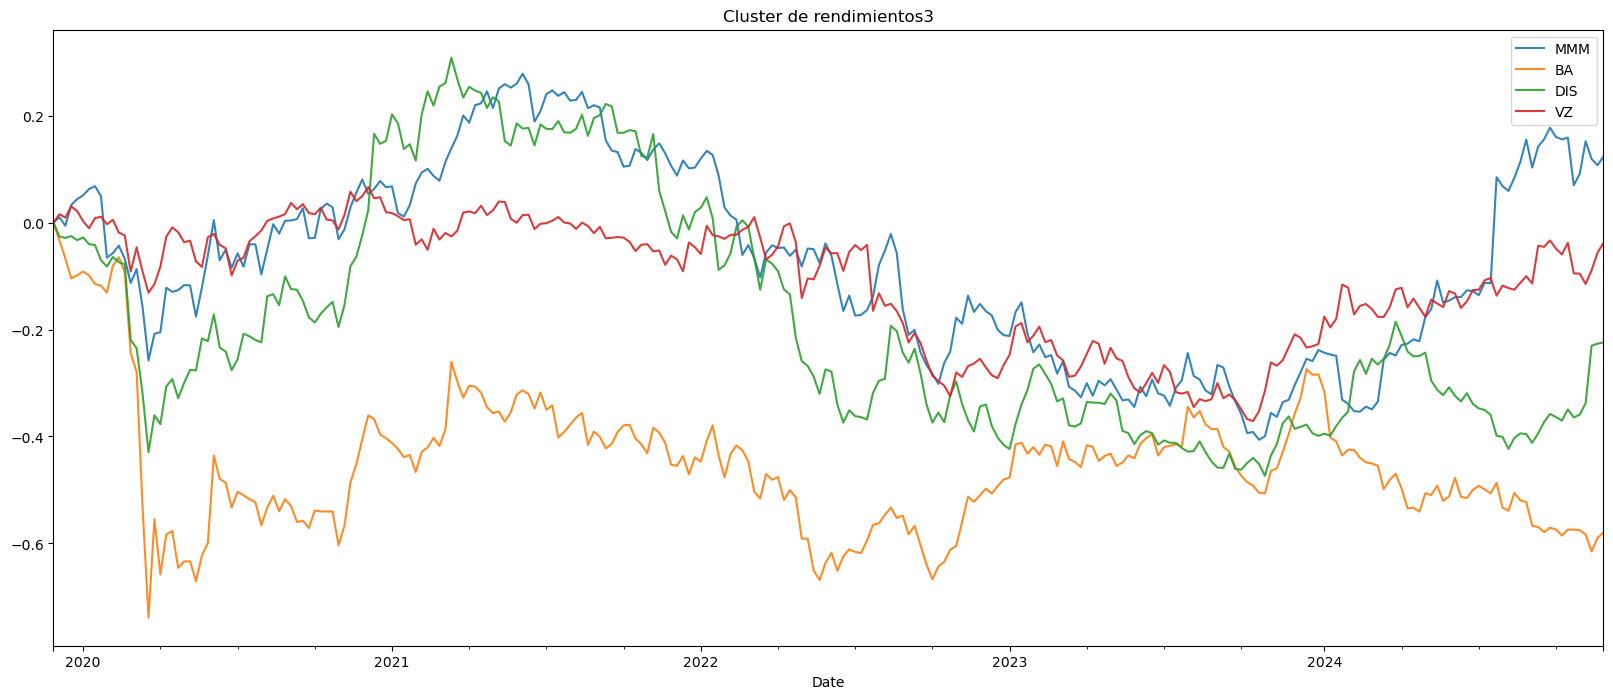

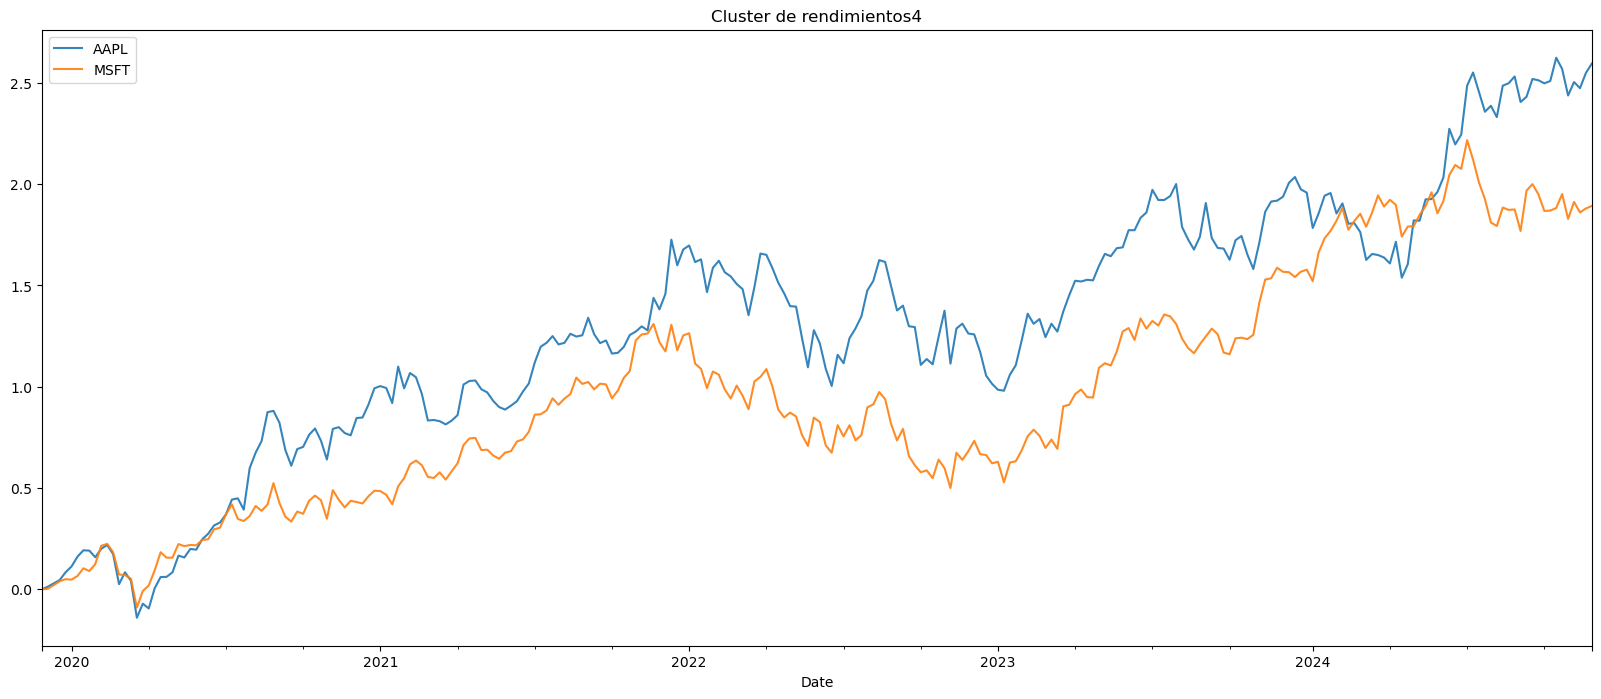

In [39]:
#Graficar todos los clusters
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_rendimientos)
    plt.title('Cluster de rendimientos' + str(c))
    plt.legend()
    plt.show()